# Part 3: Analyzing experimental data with DeerLab

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import deerlab as dl

### Learning Objectives of Part 3

- To obtain a basic understanding on how to load data from a spectrometer into a script
- To be able to do minimal pre-processing of the experimental data 
- To be able to analyze any type of dipolar EPR signal

---------------------

## 1. Loading data into DeerLab

DeerLab provides the function ``deerload`` that can load dipolar EPR data from most spectrometer file formats. The function ``deerload`` is a Python version of the very well known ``eprload`` from the EasySpin package for MATLAB. It works for 1D and 2D datasets, both real- or complex-valued. For data files in ASCII format, Numpy provides robust loading functions such as ``loadtxt`` which can be used in the same way as ``deerload``.  

First, we must determine the location of the spectrometer files we want to load and the location of the script or Jupyter notebook you are writing in. For example, consider the file structure of this workspace 

    /home
    |-----notebooks
    |      |
    |      |---03-instructor-deerlab-fitting.ipynb
    |
    +-----data
            |
            +---example_4pdeer_4.DTA
            +---example_4pdeer_4.DSC

to load the data file ``example_4pdeer_4.DTA`` we must either specify the full path stdarting from the root folder ``home`` or the relative path to the file from our ``tutorials`` folder.  

*Tipp:* In Windows computers, by right-clicking a file while pressing ``Shift`` one can select the option ``Copy as path`` to automatically copy the full path of the file. This can then be directly pasted into your script to effortlessly load the data.

The function returns two outputs: the first is the dipolar time-axis of your experiment (a vector of pulse increments), and the second is the raw experimental data as saved by your spectrometer. Here, we store them in variables named ``t`` and ``Vexp``. 

In [14]:
path = '/home/data/' # Full path
path = '../data/' # Relative path
filename = 'example_4pdeer_4.DTA' # Name of the data file

t,Vexp = dl.deerload(path + filename)


Both ``t`` and ``Vexp`` are 1D Numpy arrays with ``N`` elements.  The function ``deerload`` attempts to return the experiment time-axis ``t`` in units of microseconds, but might not be able to do so for all file formats. It is important to check that the time-axis has the correct units. 

This can be easily checked by printing the variable ``t`` or plotting the data.

0.008


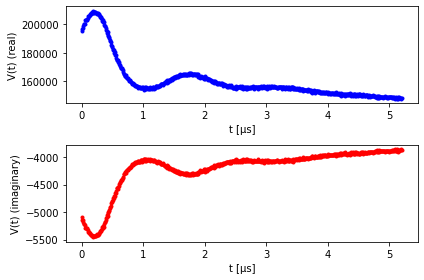

In [15]:
print(t[2]-t[1]) 

plt.subplot(211)
plt.plot(t,Vexp.real,'b.')
plt.xlabel('t [μs]')
plt.ylabel('V(t) (real)')

plt.subplot(212)
plt.plot(t,Vexp.imag,'r.')
plt.xlabel('t [μs]')
plt.ylabel('V(t) (imaginary)')

plt.tight_layout() 
plt.show()


-------------------------------

## 2. Pre-processing

While DeerLab can handle pure raw data (even in complex form) it can facilitate our analysis to perform a couple of simple pre-processing steps. 

### Phase correction

Experimental dipolar signals are most often acquired in quadrature, with the in-phase and the out-of-phase component stored as the real and the imaginary part of a complex-valued signal. If the out-of-phase components are of no relevance, it is recommendable to perform a phase correction which minimizes the imaginary component and maximizes the real component. If the signal is not complex-valued or the out-of-phase component is important, skip this step. The phase correction function ``correctphase`` takes the complex-valued signal and returns the real-valued phase-corrected dipolar signal.

### Accounting for the deadtime

DeerLab assumes that the dipolar time evolution has its zero-time inmediately after the pulse. For example: 

![title](https://jeschkelab.github.io/DeerLab/_images/sequence_4pdeer.svg)

Since experiments usually have a certain deadtime during which the echo modulation cannot be acquired, we must account for that. Sadly most spectrometers do not automatically do this and we must take care that its definition is correct. 

*Note:* This is information that must be noted by the user as DeerLab cannot robustly extract that from the data files. For example, in most PulseSPEL definition of DEER experiments, the deadtime is defined as the ``d0`` delay in commercial Bruker spectrometers. 

Let's take an example file where we know that we measured with a deadtime of 280ns. 

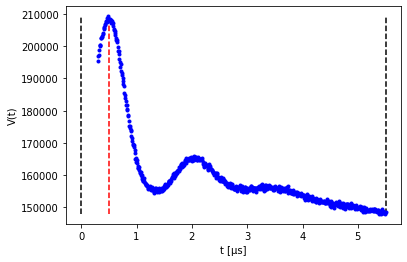

In [30]:
# Load the data
t,Vexp = dl.deerload('../data/example_4pdeer_4.DTA')

# Experiment details 
deadtime = 0.3 # μs 
tau1 = 0.5 # μs 
tau2 = 5.0 # μs 

# Phase correction
Vexp = dl.correctphase(Vexp)

# Account for the deadtime
t = t - min(t) # Set the first time interval to zero 
t = t + deadtime # Account for the deadtime

plt.plot(t,Vexp,'b.')
plt.xlabel('t [μs]')
plt.ylabel('V(t)')

# Add some vertical lines for illustration
plt.vlines(0,min(Vexp),max(Vexp),'k',linestyle='dashed')
plt.vlines(tau1+tau2,min(Vexp),max(Vexp),'k',linestyle='dashed')
plt.vlines(tau1,min(Vexp),max(Vexp),'r',linestyle='dashed')


plt.show()

## Hands-on #2: Loading and pre-processing experimental dipolar EPR data

Load the experimental 4-pulse DEER dipolar signal ``example_4pdeer_1.DTA`` located in the ``data`` folder of this workshop's workspace. The experiment was acquired with the following experimental setup: 

| Delay | Length | Description | 
| :---: | :---: | --- |
| 𝜏1 |  0.3μs |       First inter-pulse delay | 
| 𝜏2 |  4.0μs  |      Second inter-pulse delay | 
| deadtime |  0.1μs |   Acquisition deadtime | 

Pre-process the data such that the data is only real-valued and the deadtime of the experiment is accounted for. Plot the resulting pre-processed signal.


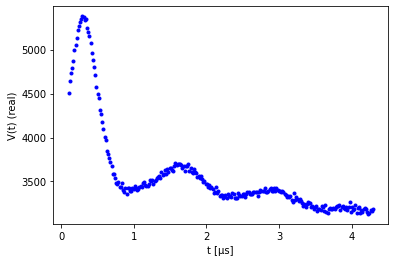

In [65]:

# The full path with filename can be directly passed to the function as well
t,Vexp = dl.deerload('../data/example_4pdeer_1.DTA') 

# Experiment details 
deadtime = 0.1 # μs 
tau1 = 0.3 # μs 
tau2 = 4.0 # μs 

# Phase correction
Vexp = dl.correctphase(Vexp)

# Deadtime correction
t = t - min(t) # Set the first time interval to zero 
t = t + deadtime # Account for the deadtime

plt.plot(t,Vexp,'b.')
plt.xlabel('t [μs]')
plt.ylabel('V(t) (real)')
plt.show()

---------------

## 3. Constructing a model of the data

DeerLab provides a very flexible framework to model dipolar signals originating from any dipolar EPR spectroscopy experiments. Choosing a model that properly describes your sample and experiment is of paramount importance. As we have seen, DeerLab's function ``dipolarmodel`` already defines the core model structure based on dipolar pathways, with the following components to be chosen:

- Distance range: Also called the interspin distance axis, is the range of distances where the distribution is defined.

- Distribution model: Describes the intra-molecular distance distribution in either a parametric (e.g. a Gaussian distribution) or a non-parametric way.

- Background model: Describes the dipolar background signal arising from the inter-molecular contributions.

- Number of pathways: Sets the number of dipolar pathways contributing to the dipolar signal.

For each of these four components, a choice needs to be made.

For example, to analyze the data with a single-pathway model using a non-parameteric distance distribution and a homogenous 3d-background (obtaining an analysis similar in spirit to DeerAnalysis and LongDistances):


In [22]:
# Define the distance range
r = np.arange(2.2,5.2,0.02)

# Construct the dipolar model
Vmodel = dl.dipolarmodel(t,r) 

print(Vmodel)

Description: Dipolar signal model
Signature: (mod, reftime, conc, P)
Constants: []
Parameter Table: 
========= ======= ======= ======== ======== ====== ====================================== 
 Name      Lower   Upper    Type    Frozen   Unit   Description                           
========= ======= ======= ======== ======== ====== ====================================== 
 mod           0       1   nonlin     No            Modulation depth                      
 reftime    -inf     inf   nonlin     No      μs    Refocusing time                       
 conc       0.01   5e+03   nonlin     No      μM    Spin concentration                    
 P             0     inf   linear     No     nm⁻¹   Non-parametric distance distribution  
========= ======= ======= ======== ======== ====== ====================================== 


The dipolar pathways of a newly constructed dipolar model are initialized at arbitrary refocusing times and fully unconstrained. This can result in unstable fits under certain conditions. It is recommended to constrain this parameter. If no further information is available this can be done by visual inspection of the data.

In [23]:
# Modify initial conditions and constraints of the refocusing time parameter
Vmodel.reftime.set(lb=0.2,ub=0.6,par0=0.4)

print(Vmodel)

Description: Dipolar signal model
Signature: (mod, reftime, conc, P)
Constants: []
Parameter Table: 
========= ======= ======= ======== ======== ====== ====================================== 
 Name      Lower   Upper    Type    Frozen   Unit   Description                           
========= ======= ======= ======== ======== ====== ====================================== 
 mod           0       1   nonlin     No            Modulation depth                      
 reftime     0.2     0.6   nonlin     No      μs    Refocusing time                       
 conc       0.01   5e+03   nonlin     No      μM    Spin concentration                    
 P             0     inf   linear     No     nm⁻¹   Non-parametric distance distribution  
========= ======= ======= ======== ======== ====== ====================================== 


The model can be easily manipulated to alter the boundaries or fix parameter to certain values. 

In [43]:
Vmodel.mod.ub = 0.6
Vmodel.conc.freeze(50)

print(Vmodel)

Description: Dipolar signal model
Signature: (mod, reftime, conc, P, P_scale)
Constants: []
Parameter Table: 
========= ======= ======= ======== ======== ====== ====================================== 
 Name      Lower   Upper    Type    Frozen   Unit   Description                           
========= ======= ======= ======== ======== ====== ====================================== 
 mod           0     0.6   nonlin     No            Modulation depth                      
 reftime    0.45    0.55   nonlin     No      μs    Refocusing time                       
 conc       0.01   5e+03   nonlin    Yes      μM    Spin concentration                    
 P             0     inf   linear     No     nm⁻¹   Non-parametric distance distribution  
========= ======= ======= ======== ======== ====== ====================================== 


which can be easily reverted

In [44]:
Vmodel.mod.ub = 1
Vmodel.conc.unfreeze()

print(Vmodel)

Description: Dipolar signal model
Signature: (mod, reftime, conc, P, P_scale)
Constants: []
Parameter Table: 
========= ======= ======= ======== ======== ====== ====================================== 
 Name      Lower   Upper    Type    Frozen   Unit   Description                           
========= ======= ======= ======== ======== ====== ====================================== 
 mod           0       1   nonlin     No            Modulation depth                      
 reftime    0.45    0.55   nonlin     No      μs    Refocusing time                       
 conc       0.01   5e+03   nonlin     No      μM    Spin concentration                    
 P             0     inf   linear     No     nm⁻¹   Non-parametric distance distribution  
========= ======= ======= ======== ======== ====== ====================================== 


### Constraining the model based on experimental pulse delays

The refocusing times can be strongly constrained by knowing the experimental pulse sequence delays used to acquire the data. If the experiment used to acquire the data is known, as well as its pulse delays, then it is strongly recommended do so.

DeerLab provides a selection of experimental information generators for some of the most widely employed experimental methods. These are functions that take the pulse sequence delays, and return an object with specific information about the experiment. This can be passed to the ``dipolarmodel`` function via the ``experiment`` keyword argument, to incorporate the experiment information on the model and constrain some of its parameters. 

These experiment models can also be used to easily and robustly introduce further dipolar pathways into the model. We will explore this later. 

For example, for the 4-pulse DEER experiment, the corresponding model (as shown in the documentation) is: 

<img src="https://raw.githubusercontent.com/JeschkeLab/DeerLabWorkshop2022/main/images/4pdeer_pathways_docs.png" alt="drawing" style="width:900px;"/>


And our pathway of interest is pathway 1 (the "intended" pathway) and neglect any other pathways. 

In [31]:
# Experiment details 
deadtime = 0.3 # μs 
tau1 = 0.5 # μs 
tau2 = 5.0 # μs 

my4pdeer = dl.ex_4pdeer(tau1,tau2,pathways=[1])

Vmodel = dl.dipolarmodel(t,r, experiment=my4pdeer) 

print(Vmodel)

Description: Dipolar signal model
Signature: (mod, reftime, conc, P)
Constants: []
Parameter Table: 
========= ======= ======= ======== ======== ====== ====================================== 
 Name      Lower   Upper    Type    Frozen   Unit   Description                           
========= ======= ======= ======== ======== ====== ====================================== 
 mod           0       1   nonlin     No            Modulation depth                      
 reftime    0.45    0.55   nonlin     No      μs    Refocusing time                       
 conc       0.01   5e+03   nonlin     No      μM    Spin concentration                    
 P             0     inf   linear     No     nm⁻¹   Non-parametric distance distribution  
========= ======= ======= ======== ======== ====== ====================================== 


--------------------------

## 4. Fitting the model to the data


In [32]:
results = dl.fit(Vmodel,Vexp)

For just a quick display of the results, you can use the ``plot()`` method of the ``results`` object that will display a figure with you experimental data, the corresponding fit including confidence bands. This allows a quick visual assessment of whether the model has been correctly fitted to the data. 

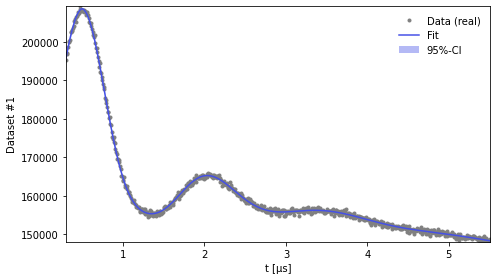

In [37]:
results.plot(axis=t,xlabel='t [μs]')
plt.show() 

----------------------

## Hands-on 3: Fitting a 4-pulse DEER signal

Back to the experimental 4-pulse DEER dipolar signal ``example_4pdeer_1.DTA`` acquired with the following experimental setup: 

    tau1 = 0.3      # First inter-pulse delay, μs
    tau2 = 4.0      # Second inter-pulse delay, μs
    deadtime = 0.1  # Acquisition deadtime, μs

Complete the following script to construct the dipolar model and fit the it to the experimental data.

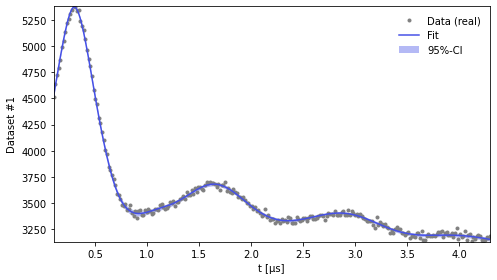

In [66]:
# The full path with filename can be directly passed to the function as well
t,Vexp = dl.deerload('../data/example_4pdeer_1.DTA') 

# Experiment details 
deadtime = 0.1 # μs 
tau1 = 0.3 # μs 
tau2 = 4.0 # μs 

# Phase correction
Vexp = dl.correctphase(Vexp)

# Deadtime correction
t = t - min(t) # Set the first time interval to zero 
t = t + deadtime # Account for the deadtime

# Experiment information
my4pdeer = dl.ex_4pdeer(tau1,tau2,pathways=[1])

# Construct the model
Vmodel = dl.dipolarmodel(t,r, experiment=my4pdeer) 

# Fit the model to the data
results = dl.fit(Vmodel,Vexp)

# Print the data and fit
results.plot(axis=t,xlabel='t [μs]')
plt.show() 

--------------------

## 5. Goodness-of-fit & Uncertainties

For a quick summary of the fit results, including goodness-of-fit statistics and the fitted model parameter values (including 95% confidence intervals), can be accessed by just printing the results object

In [45]:
print(results)

Goodness-of-fit: 
========= ============= ============ ======== ========== 
 Dataset   Noise level   Reduced 𝛘2    RMSD      AIC     
========= ============= ============ ======== ========== 
   #1        24.222        0.967      21.631   2990.080  
========= ============= ============ ======== ========== 
Model hyperparameters: 
 Regularization parameter  
          0.090            
Model parameters: 
=========== =================== ========================= ====== ====================================== 
 Parameter   Value               95%-Confidence interval   Unit   Description                           
=========== =================== ========================= ====== ====================================== 
 mod         0.303               (0.300,0.305)                    Modulation depth                      
 reftime     0.499               (0.498,0.501)              μs    Refocusing time                       
 conc        148.131             (143.736,152.527)          μM    Sp

These quantities and their uncertinaties are easily accessed from the ``results`` object.

In [46]:
mod_fit = results.mod 
conc_fit = results.conc

print(mod_fit,conc_fit)

0.30251290471696923 148.13120623239072


For example in the case of non-parametric distance distributions

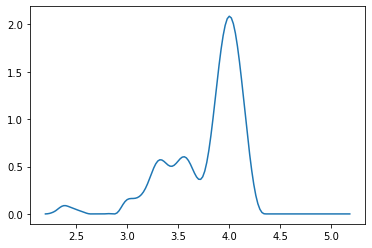

In [57]:
Pfit = results.P

plt.plot(r,Pfit)
plt.show()

Each parameter has an associated ``<parameterName>Uncert`` quantity that contains all the information related to its uncertainty. The most information field is the ``pardist()`` method which the returns the probability density function that quantifies the uncertinaty of the parameter. 

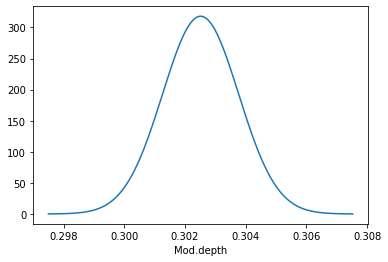

mean:  [0.3025129]
std:  [0.00125441]


In [53]:
# Extract the uncertianty quantification of the modulation depth parameter
mod_uq = results.modUncert 

# Get the uncertainty distribution
x,pdf = mod_uq.pardist()

plt.plot(x,pdf)
plt.xlabel('Mod.depth')
plt.show() 

print('mean: ',mod_uq.mean)
print('std: ',mod_uq.std)

Usually, it is enough to report on the uncertainty using confidence intervals. These can be easily computed using the ``ci()`` method of the uncertainty quantification results. The method returns a list with the first element being the lower bound and the second element the upper bound of the confidence interval.

In [54]:
mod_ci95 = mod_uq.ci(95)

print(mod_ci95)

[0.30005431 0.3049715 ]


------------------------

## Hands-on 4: Computing confidence intervals

For the current ``results`` object. Extract the uncertinaty distribution and the confidence interval bounds of the spin concentration parameter ``conc``.

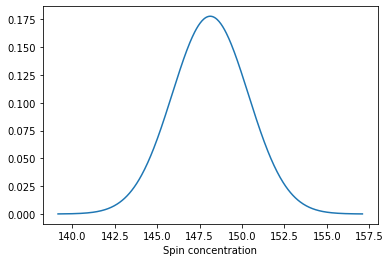

[143.7355797  152.52683277]


In [58]:
# Extract the uncertianty quantification of the modulation depth parameter
conc_uq = results.concUncert 

# Get the uncertainty distribution
x,pdf = conc_uq.pardist()

plt.plot(x,pdf)
plt.xlabel('Spin concentration')
plt.show() 

conc_ci95 = conc_uq.ci(95)

print(conc_ci95)

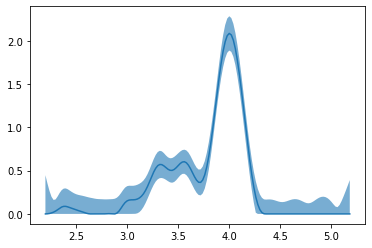

In [64]:
Pci95 = results.PUncert.ci(95)

plt.plot(r,Pfit)
plt.fill_between(r,Pci95[:,0],Pci95[:,1],alpha=0.6)
plt.show()